# **Data about coins and bills circulation in Brazil**


***Creating in:*** Brazil, January 2024

***By:*** SRS

 ***Data origin:***  https://dadosabertos.bcb.gov.br/dataset?res_format=API

Comments :
  * In dataframe:  every column beginning with ***underline*** is a column created in development

**Information from the official website**

The Central Bank of Brazil (BCB) uses various sources and methods to estimate the quantity of coins and banknotes in circulation in the country. Some of the main methods include:

Production and Destruction Control: The Central Bank is responsible for authorizing the production of new banknotes and coins, as well as the withdrawal of damaged or worn-out notes from circulation. It maintains strict control over these processes.

Electronic Systems and Banks: The BCB uses electronic systems to monitor financial transactions and money movements through banks. Banks provide information on withdrawals and deposits of physical money.

Surveys and Studies: The Central Bank conducts surveys and studies to estimate the amount of money in circulation. This may include conducting surveys on the use of money in daily transactions, the behavior of withdrawals and deposits at ATMs, among others.

Monitoring of Reserves in Commercial Banks: The BCB also monitors the reserves of money held by commercial banks. Banks are required to maintain certain reserve levels, and the Central Bank can use this information to make estimates about the amount of money in circulation.

Economic Data: The BCB also analyzes economic data, such as inflation rates, economic growth, and consumption patterns, to make projections about the demand for physical money.

It is important to note that these estimates are constantly updated as new data becomes available. The Central Bank uses an integrated approach, combining various sources of information to obtain a more comprehensive view of the quantity of coins and banknotes in circulation.

In [233]:
# Import library
import requests
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns


from threading import Condition


# Importing information by API

In [234]:
# Search through an API for available information (using pagination)

df_data_diary_original = pd.DataFrame()
_skip_index = 0

while True:
    url = f'https://olinda.bcb.gov.br/olinda/servico/mecir_dinheiro_em_circulacao/versao/v1/odata/informacoes_diarias?$top=10000&$skip={_skip_index}&$format=json'
    _request = requests.get(url)
    _informations = _request.json()
    df_data_diary_temp = pd.DataFrame(_informations["value"])
    if len(_informations['value']) < 1:
        break
    df_data_diary_original = pd.concat([df_data_diary_original, df_data_diary_temp])
    _skip_index += 10000

df_data_diary_original.head(10)

,Data,Quantidade,Valor,Denominacao,Especie
0,1994-10-03,692701959,6.927020e+06,0.01,Moedas
1,1994-10-03,462277579,2.311388e+07,0.05,Moedas
2,1994-10-03,404559065,4.045591e+07,0.10,Moedas
3,1994-10-03,1492870,3.732175e+05,0.25,Moedas
4,1994-10-03,278901842,1.394509e+08,0.50,Moedas
5,1994-10-03,267853898,2.678539e+08,1.00,Cédulas
6,1994-10-03,181609358,1.816094e+08,1.00,Moedas
7,1994-10-03,252922174,1.264611e+09,5.00,Cédulas
8,1994-10-03,273630983,2.736310e+09,10.00,Cédulas
9,1994-10-03,28945486,1.447274e+09,50.00,Cédulas


In [235]:
# Renaming columns
df_data_diary_original.columns = ['Date','Quantity','Value','Nominal','Species']
df_data_diary_original.head(5)


,Date,Quantity,Value,Nominal,Species
0,1994-10-03,692701959,6.927020e+06,0.01,Moedas
1,1994-10-03,462277579,2.311388e+07,0.05,Moedas
2,1994-10-03,404559065,4.045591e+07,0.10,Moedas
3,1994-10-03,1492870,3.732175e+05,0.25,Moedas
4,1994-10-03,278901842,1.394509e+08,0.50,Moedas


In [236]:
# Quantity of Lines and columns
print(f'Lines: {df_data_diary_original.shape[0]} and columns: {df_data_diary_original.shape[1]}')


Lines: 93105 and columns: 5


In [237]:
# Dataset structure
df_data_diary_original.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 93105 entries, 0 to 3104
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      93105 non-null  object 
 1   Quantity  93105 non-null  int64  
 2   Value     93105 non-null  float64
 3   Nominal   93105 non-null  object 
 4   Species   93105 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 4.3+ MB


# Data Wrangling

In [238]:
# Created a copy of the data
df_diary = df_data_diary_original
df_diary.head(5)

,Date,Quantity,Value,Nominal,Species
0,1994-10-03,692701959,6.927020e+06,0.01,Moedas
1,1994-10-03,462277579,2.311388e+07,0.05,Moedas
2,1994-10-03,404559065,4.045591e+07,0.10,Moedas
3,1994-10-03,1492870,3.732175e+05,0.25,Moedas
4,1994-10-03,278901842,1.394509e+08,0.50,Moedas


In [239]:
# Missing values
df_diary.isnull().sum()


Date        0
Quantity    0
Value       0
Nominal     0
Species     0
dtype: int64

In [240]:
# Converting the informations about date
_Date = pd.to_datetime(df_diary['Date'])

# Creating columns for the day, month and year
df_diary['_Year']   = _Date.dt.year
df_diary['_Month']  = _Date.dt.month
df_diary['_Day']    = _Date.dt.day

# Converting values divided by one million
df_diary['_Nominal'] = df_diary['Nominal'].astype(float)
df_diary['_Value']   =  (((df_diary['_Nominal']) * (df_diary['Quantity'])) / 1000000).round(5) # 10 million

df_diary.head(2)


,Date,Quantity,Value,Nominal,Species,_Year,_Month,_Day,_Nominal,_Value
0,1994-10-03,692701959,6927019.59,0.01,Moedas,1994,10,3,0.01,6.92702
1,1994-10-03,462277579,23113878.95,0.05,Moedas,1994,10,3,0.05,23.11388


In [241]:
# Substituting the values in the column according to the conditions
df_diary['_Species'] = df_diary['Species'].replace({'Moedas': 'Coin', 'Cédulas': 'Paper'})
df_diary.head()


,Date,Quantity,Value,Nominal,Species,_Year,_Month,_Day,_Nominal,_Value,_Species
0,1994-10-03,692701959,6.927020e+06,0.01,Moedas,1994,10,3,0.01,6.92702,Coin
1,1994-10-03,462277579,2.311388e+07,0.05,Moedas,1994,10,3,0.05,23.11388,Coin
2,1994-10-03,404559065,4.045591e+07,0.10,Moedas,1994,10,3,0.10,40.45591,Coin
3,1994-10-03,1492870,3.732175e+05,0.25,Moedas,1994,10,3,0.25,0.37322,Coin
4,1994-10-03,278901842,1.394509e+08,0.50,Moedas,1994,10,3,0.50,139.45092,Coin


In [242]:
# Dataset structure (new)
df_diary.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 93105 entries, 0 to 3104
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      93105 non-null  object 
 1   Quantity  93105 non-null  int64  
 2   Value     93105 non-null  float64
 3   Nominal   93105 non-null  object 
 4   Species   93105 non-null  object 
 5   _Year     93105 non-null  int64  
 6   _Month    93105 non-null  int64  
 7   _Day      93105 non-null  int64  
 8   _Nominal  93105 non-null  float64
 9   _Value    93105 non-null  float64
 10  _Species  93105 non-null  object 
dtypes: float64(3), int64(4), object(4)
memory usage: 8.5+ MB


# Export data


In [243]:
# Saving data in CSV file
from datetime import datetime
now = datetime.now()

# File name
file_name = f'Currency_Circulation_{now.strftime("%Y-%m-%d_%H-%M-%S")}.csv'

# Salvar o dataframe no arquivo CSV
df_diary.to_csv(file_name, index=False)

print(f'Datafile {file_name} saved!')


Datafile Currency_Circulation_2024-03-03_19-52-37.csv saved!


# Data exploration - just for an initial demonstration of how the data looks

In [244]:
# Grouping by species and nominal and counting the number of elements
df_group = df_diary.groupby(['_Species', '_Nominal']).size().reset_index(name='Count')
df_group


,_Species,_Nominal,Count
0,Coin,0.01,7382
1,Coin,0.05,7382
2,Coin,0.10,7382
3,Coin,0.25,7382
4,Coin,0.50,7382
5,Coin,1.00,7382
6,Paper,1.00,7382
7,Paper,2.00,5580
8,Paper,5.00,7382
9,Paper,10.00,7382


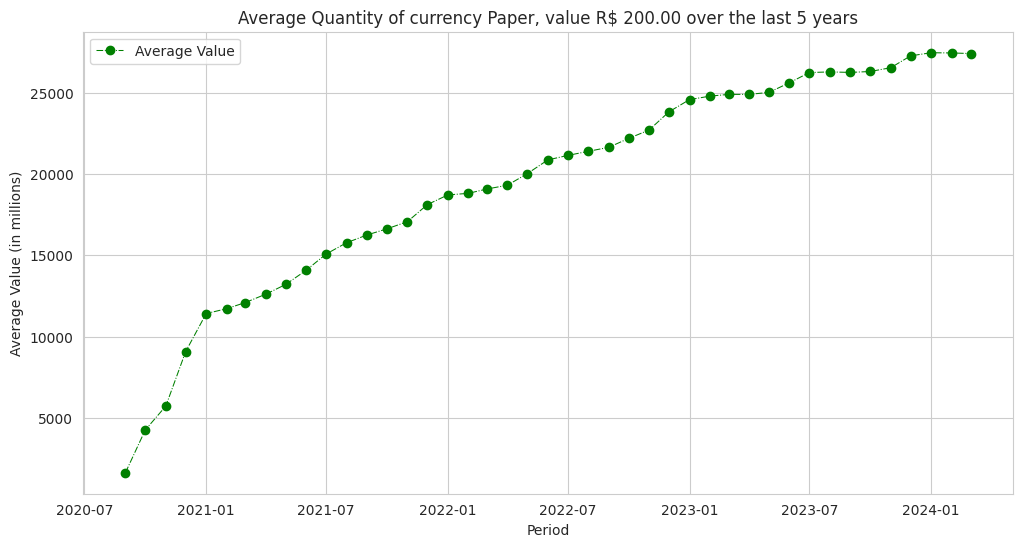

In [245]:
# Parameters
_species = 'Paper'
_nominal = 200.00

# Filter the DataFrame
df_filtered = df_diary[(df_diary['_Species'] == _species) & (df_diary['_Nominal'] == _nominal)]

# Group by year and month and calculate the average of the values
df_grouped = df_filtered.groupby(['_Year', '_Month']).agg({'_Value': 'mean'}).reset_index()

# # Create a new field with the full date
df_grouped['_Date'] = pd.to_datetime(df_grouped['_Year'].astype(str) + '-' + df_grouped['_Month'].astype(str))

# Filter the last 5 years
last_years = df_grouped['_Year'].max() - 4
df_grouped = df_grouped[df_grouped['_Year'] >= last_years]

# Create the line graph
plt.figure(figsize=(12, 6))
plt.plot(df_grouped['_Date'], df_grouped['_Value'], marker='o', label='Average Value', linestyle='-.', linewidth=0.75, color='green')
plt.xlabel('Period')
plt.ylabel('Average Value (in millions)')
plt.title(f'Average Quantity of currency {_species}, value R$ { _nominal:.2f} over the last 5 years')
plt.legend()
plt.grid(True)
plt.show()


In [246]:
# Parameters
_species = 'Paper'

# selected data
df_filtered = df_diary.loc[(df_diary.loc[:, '_Species'] == _species) & (df_diary.loc[:, '_Year'] < 2024)]
df_filtered.sample(5)


,Date,Quantity,Value,Nominal,Species,_Year,_Month,_Day,_Nominal,_Value,_Species
2463,2008-11-28,1260682188,6.303411e+10,50.00,Cédulas,2008,11,28,50.0,63034.10940,Paper
6898,2019-06-21,544624226,5.446242e+09,10.00,Cédulas,2019,6,21,10.0,5446.24226,Paper
3760,2006-03-30,524853469,5.248535e+08,1.00,Cédulas,2006,3,30,1.0,524.85347,Paper
8378,2022-10-25,148665583,1.486656e+08,1.00,Cédulas,2022,10,25,1.0,148.66558,Paper
8046,2022-09-20,575461159,5.754612e+09,10.00,Cédulas,2022,9,20,10.0,5754.61159,Paper


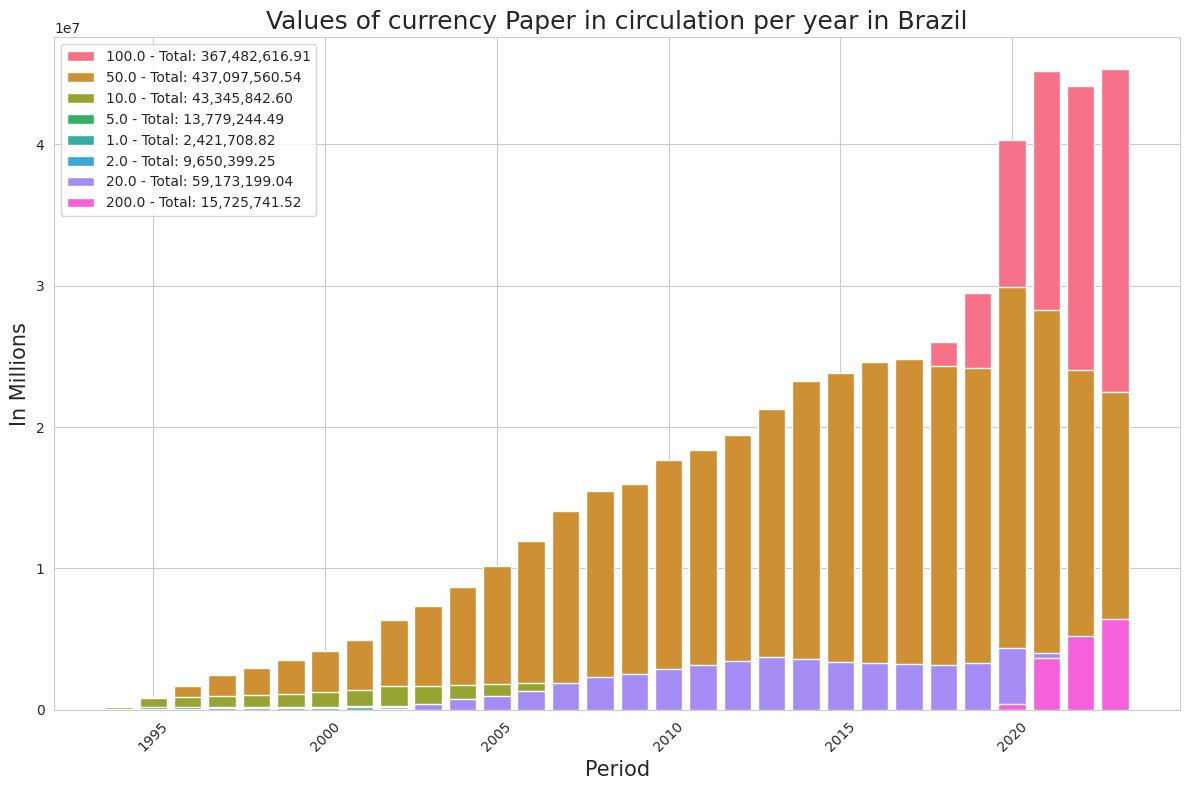

In [247]:
# Parameters
_species = 'Paper'

# selected data
df_filtered = df_diary.loc[(df_diary['_Species'] == _species) & (df_diary['_Year'] < 2024)]

# Calculate the total values for each currency in each year
total_values = df_filtered.groupby(['_Nominal', '_Year'])['_Value'].sum().reset_index()

# Sort the coins by the total value in each year, from highest to lowest
sorted_currency = total_values.groupby('_Year')['_Nominal'].apply(lambda x: x.sort_values(ascending=False)).reset_index(drop=True)

# Function to create the graph with the option to change the colour palette and legends with values
def create_graphic(colour_palettes):
    fig, ax = plt.subplots(figsize=(12, 8))

    for i, currency in enumerate(sorted_currency.unique()):
        data_currency = total_values[total_values['_Nominal'] == currency]
        ax.bar(data_currency['_Year'], data_currency['_Value'], label=f'{currency} - Total: {data_currency["_Value"].sum():,.2f}', color=colour_palettes[i])

    ax.set_xlabel('Period', size=15)
    ax.set_ylabel('In Millions', size=15)
    ax.set_title('Values of coins in circulation per year in Brazil', size=18)
    plt.title(f'Values of currency {_species} in circulation per year in Brazil', size=18)
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Show the graph
    plt.show();

# Standard seaborn colour palette
standard_colour_palette = sns.color_palette("husl", n_colors=len(sorted_currency.unique()))

# Create a graphic with a standard colour palette
create_graphic(standard_colour_palette)

# Option to change the colour palette
#new_colour_palette = sns.color_palette("deep", n_colors=len(sorted_moedas.unique()))
#create_graphic(new_colour_palette)


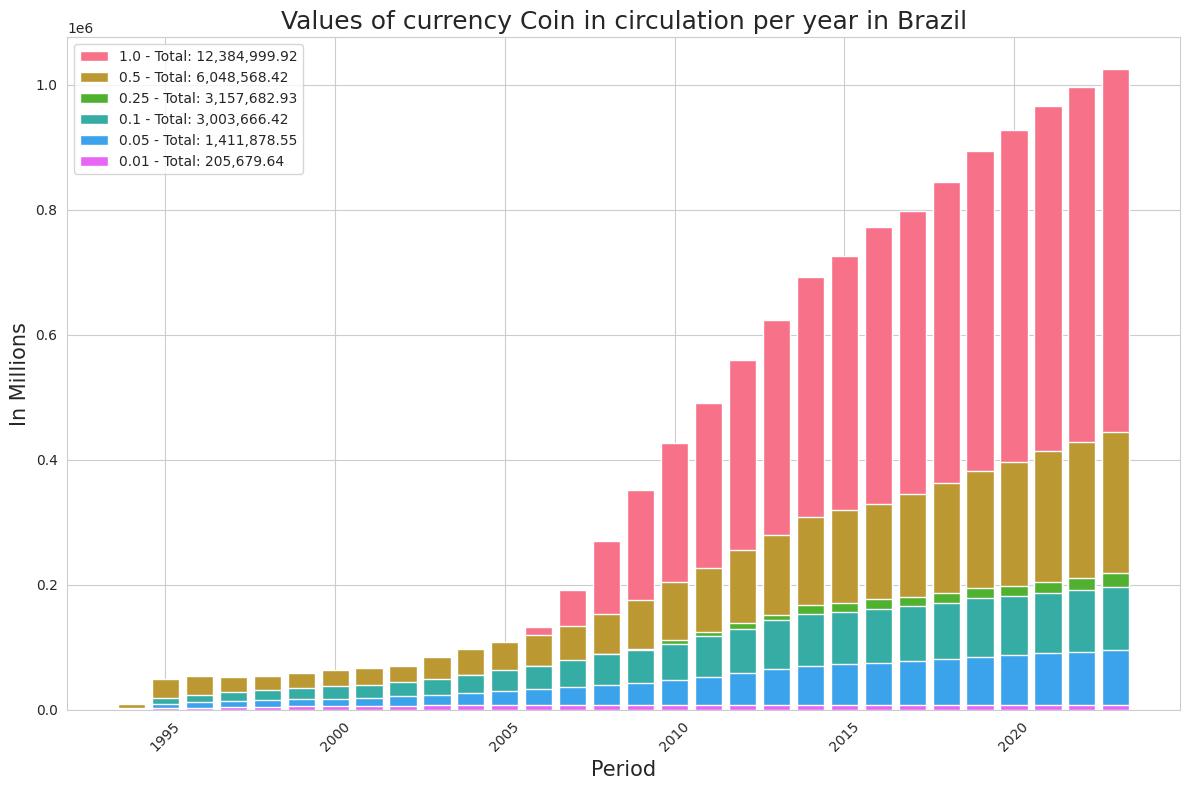

In [248]:
# Parameters
_species = 'Coin'

# selected data
df_filtered = df_diary.loc[(df_diary['_Species'] == _species) & (df_diary['_Year'] < 2024)]

# Calculate the total values for each currency in each year
total_values = df_filtered.groupby(['_Nominal', '_Year'])['_Value'].sum().reset_index()

# Sort the coins by the total value in each year, from highest to lowest
sorted_currency = total_values.groupby('_Year')['_Nominal'].apply(lambda x: x.sort_values(ascending=False)).reset_index(drop=True)

# Function to create the graph with the option to change the colour palette and legends with values
def create_graphic(colour_palettes):
    fig, ax = plt.subplots(figsize=(12, 8))

    for i, currency in enumerate(sorted_currency.unique()):
        data_currency = total_values[total_values['_Nominal'] == currency]
        ax.bar(data_currency['_Year'], data_currency['_Value'], label=f'{currency} - Total: {data_currency["_Value"].sum():,.2f}', color=colour_palettes[i])

    ax.set_xlabel('Period', size=15)
    ax.set_ylabel('In Millions', size=15)
    ax.set_title('Values of coins in circulation per year in Brazil', size=18)
    plt.title(f'Values of currency {_species} in circulation per year in Brazil', size=18)
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Show the graph
    plt.show();

# Standard seaborn colour palette
standard_colour_palette = sns.color_palette("husl", n_colors=len(sorted_currency.unique()))

# Create a graphic with a standard colour palette
create_graphic(standard_colour_palette)

# Option to change the colour palette
#new_colour_palette = sns.color_palette("deep", n_colors=len(sorted_moedas.unique()))
#create_graphic(new_colour_palette)
